# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

---

# Setup

In [1]:
%run "../config/notebook_settings.py"

from helpers.utilities import Timer, get_logger
from helpers.text_processing import count_tokens

def get_project_directory():
    return os.getcwd().replace('/source/executables', '')

print(get_project_directory())

/Users/shanekercheval/repos/nlp-template


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

In [2]:
with Timer("Loading Data"):
    path = os.path.join(get_project_directory(), 'artifacts/data/processed/un-general-debates-blueprint.pkl')
    df = pd.read_pickle(path)

Started: Loading Data
Finished (0.95 seconds)


---

In [3]:
hlp.pandas.numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
session,"7,507",0,0.0%,0,0.0%,49.6,12.9,0.3,-0.2,-1.1,25,31.0,39.0,51.0,61.0,67.0,70
year,"7,507",0,0.0%,0,0.0%,"1,994.6",12.9,0.0,-0.2,-1.1,"1,970","1,976.0","1,984.0","1,996.0","2,006.0","2,012.0","2,015"
num_tokens,"7,507",0,0.0%,0,0.0%,"1,480.3",635.2,0.4,1.1,1.7,187,793.6,"1,005.5","1,358.0","1,848.0","2,336.4","5,688"
text_length,"7,507",0,0.0%,0,0.0%,"17,967.3","7,860.0",0.4,1.1,1.8,"2,362","9,553.8","12,077.0","16,424.0","22,479.5","28,658.2","72,041"


In [4]:
hlp.pandas.non_numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"7,507",0,0.0%,ALB,199,2.7%
country_name,"7,507",0,0.0%,Albania,199,2.7%
speaker,"7,507",0,0.0%,<unknown>,"5,429",72.3%
position,"7,507",0,0.0%,<unknown>,114,1.5%
text,"7,507",0,0.0%,33: May I first convey to our [...],"7,507",100.0%
tokens,"7,507",0,0.0%,"['may', 'first', 'convey', 'pr[...]","7,507",100.0%


---

In [5]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

---

In [6]:
count_tokens(df['tokens']).head(20)

,frequency
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


---

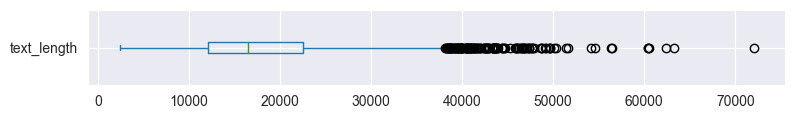

In [7]:
df['text_length'].plot(kind='box', vert=False, figsize=(9, 1));

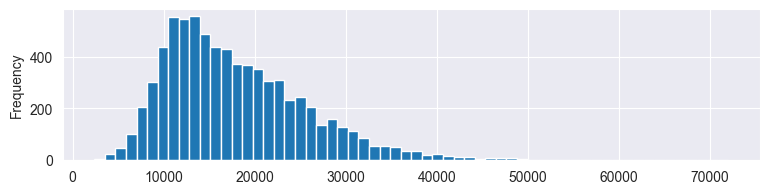

In [8]:
df['text_length'].plot(kind='hist', bins=60, figsize=(9, 2));

---

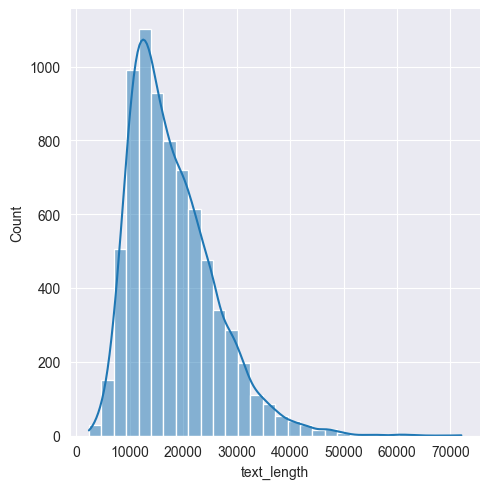

In [9]:
import seaborn as sns

#plt.figure(figsize=(9, 1))
sns.displot(df['text_length'], bins=30, kde=True);

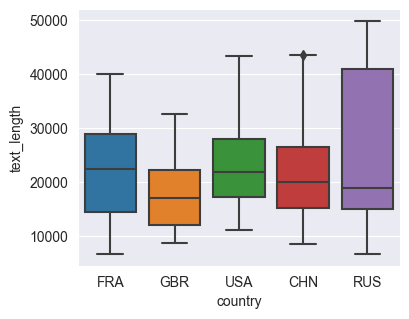

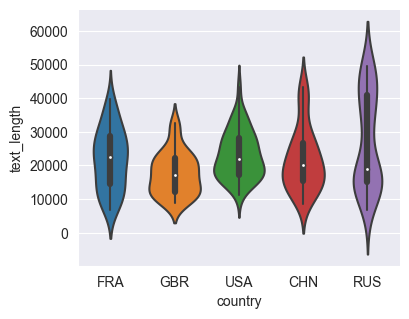

In [10]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="text_length", kind='box')
g.fig.set_size_inches(4, 3)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="country", y="text_length", kind='violin')
g.fig.set_size_inches(4, 3)
g.fig.set_dpi(100)

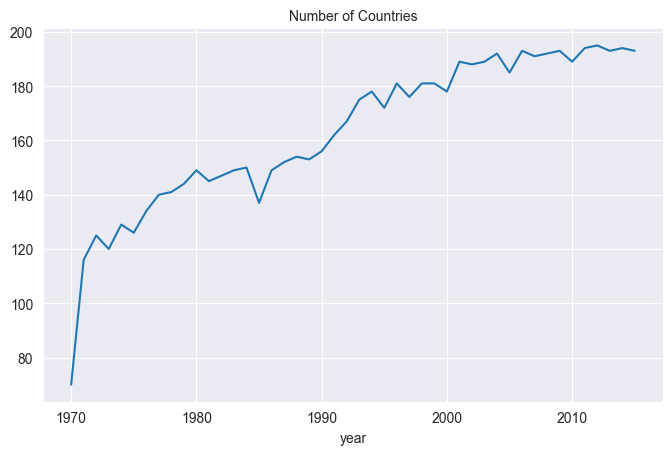

In [11]:
assert not df[['year', 'country']].duplicated().any()
df.groupby('year').size().plot(title="Number of Countries", 
#                               fig_dpi=100,
#                               figsize=
                              );

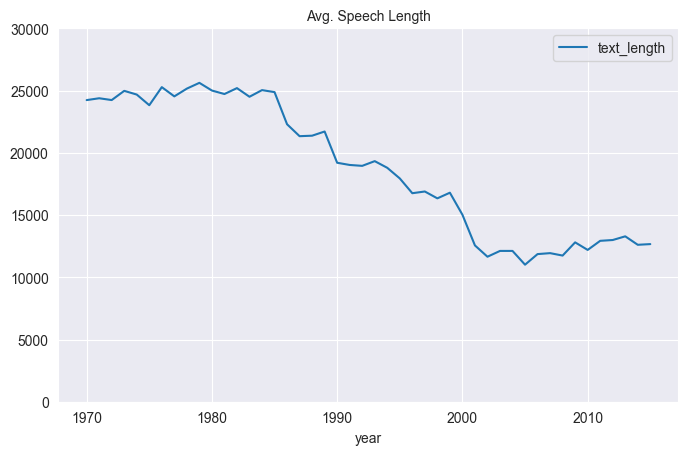

In [12]:
df.groupby('year').agg({'text_length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000));

In [13]:
(hlp.plot.STANDARD_WIDTH / 1.2, hlp.plot.STANDARD_HEIGHT / 1.2)

(8.333333333333334, 5.150283239582122)